In [12]:
#Import libraries and load data frame
import pandas as pd
import numpy as np
from numpy import sort
import xgboost as xgb
from xgboost import XGBClassifier
import lime
from lime.lime_tabular import LimeTabularExplainer

from joblib import dump

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score



In [13]:
#Load data

trainDF = pd.read_csv('../data/raw/train.csv')
testDF = pd.read_csv('../data/raw/test.csv')

#Remove Id columns as irrelevant and data cleaning such as make all columns absolute values

trainDF_cleaned = trainDF.copy()
trainDF_cleaned = trainDF_cleaned.abs()
trainDF_cleaned.drop(['Id_old','Id'], axis=1, inplace=True)
target = trainDF_cleaned.pop('TARGET_5Yrs')

testDF_cleaned = testDF.copy()
testDF_cleaned = testDF_cleaned.abs()
testDF_cleaned.drop(['Id_old','Id'], axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GP       8000 non-null   float64
 1   MIN      8000 non-null   float64
 2   PTS      8000 non-null   float64
 3   FGM      8000 non-null   float64
 4   FGA      8000 non-null   float64
 5   FG%      8000 non-null   float64
 6   3P Made  8000 non-null   float64
 7   3PA      8000 non-null   float64
 8   3P%      8000 non-null   float64
 9   FTM      8000 non-null   float64
 10  FTA      8000 non-null   float64
 11  FT%      8000 non-null   float64
 12  OREB     8000 non-null   float64
 13  DREB     8000 non-null   float64
 14  REB      8000 non-null   float64
 15  AST      8000 non-null   float64
 16  STL      8000 non-null   float64
 17  BLK      8000 non-null   float64
 18  TOV      8000 non-null   float64
dtypes: float64(19)
memory usage: 1.2 MB


In [14]:
#Split data

X_train, X_val, y_train, y_val = train_test_split (trainDF_cleaned, target, test_size=0.2, random_state=8)

np.save('../data/processed/X_train', X_train)
np.save('../data/processed/X_val',   X_val)

np.save('../data/processed/y_train', y_train)
np.save('../data/processed/y_val',   y_val)


In [34]:
## REMOVE? Not that useful a score Define a cross validation function

def cross_val(classifier, num_splits=10):
    
    # Initialize classifier
    model = classifier

    # Obtain scores of cross-validation
    scores = cross_val_score(model, X, y, cv=num_splits)

    # Display accuracy
    print('Accuracy:', np.round(scores, 2))

    # Display mean accuracy
    print('Accuracy mean: %0.2f' % (scores.mean()))
    

In [16]:
#Build pipeline

full_pipeline = Pipeline([('imputer', SimpleImputer()),  ('scaler', StandardScaler()),

('xgb', XGBClassifier())])


In [17]:
# Fit and predict using pipeline

xgb_model = full_pipeline.fit(X_train,y_train)
pred_val = full_pipeline.predict(X_val)

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:34:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


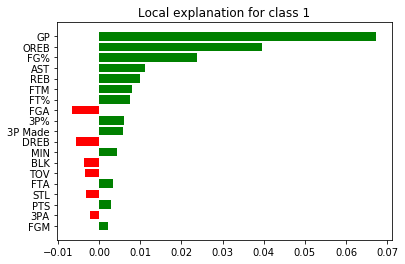

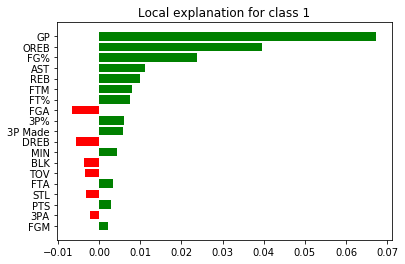

In [31]:
target_classes=[0, 1]

lime_explainer = LimeTabularExplainer(X_train,
      feature_names=trainDF_cleaned.columns,
      class_names=target_classes,
      mode='classification',
      discretize_continuous=False
)

exp = lime_explainer.explain_instance(
    X_val.iloc[0], 
    xgb_model.predict_proba, 
    top_labels=1,
    num_features=20)

exp.as_pyplot_figure()

In [ ]:
#Optional: Parameter grid for pipeline

##param1 = [,..]

##param_grid = dict(xgb__paramname=param1, xbg__param2name=param2)

In [6]:
cross_val(xgb(n_estimators=5))

NameError: name 'xgb' is not defined

In [13]:
# Print confusion matrix to evaluate classification accuracy
cm_val = confusion_matrix(y_val, pred_val)
print("Confusion Matrix \n", cm_val)


# Model Accuracy, how often is the classifier correct?
print("Accuracy:",accuracy_score(y_val, pred_val))

#AUC score
auc_val = roc_auc_score(y_val,pred_val)
print('AUC: %.2f' % auc_val)

Confusion Matrix 
 [[   8  249]
 [  22 1321]]
Accuracy: 0.830625
AUC: 0.51
